# 五、构造算法

## 1. Monte-Carlo构造法

之前的章节介绍到，在信道极化的过程中，我们只能知道一个大概的大小关系，$I(W')<I(W)<I(W'')$，而这些新信道容量的具体值并没有一个简单通用的计算公式。在无法准确计算时，我们可以使用Monte-Carlo法进行估计。

为简单起见，我们先以传输正确率的估计为例，毕竟对二进制信道而言，容量越大，其传输正确率也越高。具体做法是，在每一轮仿真中，首先均匀随机生成一个比特序列$u_{1:N}$，对其进行极化变换得到$x_{1:N}=u_{1:N}\mathbf{G}_N\mathbf{B}_N$，然后将这个序列通过信道，得到输出序列$y_{1:N}$。最后，我们依次计算：

$$\Pr(U_i=u_i|Y_{1:N}=y_{1:N},U_{1:i-1}=u_{1:i-1}),u_i\in\{0,1\}$$

这样便得到了$N$个条件概率分布。注意，条件部分是真实值$u_{1:i-1}$而不是估计值，这与SC译码过程有所不同，因为在这里我们的目的是为了估计极化信道的传输正确率，而不是为了进行译码，自然也不受到实际通信系统的能力限制。

接下来，我们对$N$个极化信道的传输正确率进行一次更新。具体来说，若使用ML准则对上述条件概率分布进行判决得到的结果$\hat{u}_i\neq u_i$，则说明极化信道$W_N^{(i)}$在该次实验中传输错误，发生了比特翻转；若$\hat{u}_i\neq u_i$，则说明在该次实验中传输正确。将这个结果记录下来，每次实验都相当于同时对$N$个极化信道进行了测试。最后计算一下平均正确率，就完成了$N$个极化信道的Monte-Carlo仿真。

我们简单写一下相关代码：

In [1]:
import plcoding
from plcoding.cpp_core.iterator import PolarIterator
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 初始化系统参数和极化码迭代器
N, q = 1024, 2
pIter = PolarIterator(N, q)
flip_prob = 0.11

In [3]:
def simulate():
    # 生成一批输入输出数据
    u = np.random.choice(a=q, p=np.array([0.5, 0.5]), size=(N,))
    x = plcoding.basic_encode(u)[plcoding.bitrev_perm(N)]
    y = np.mod(x + (np.random.rand(N) < flip_prob), q)
    # 使用极化迭代器计算N个极化信道对应的条件概率
    Px = np.empty(shape=(N, q))
    Px[np.arange(N), y] = 1 - flip_prob
    Px[np.arange(N), 1 - y] = flip_prob
    pIter.set_priors(Px)
    # 开始迭代计算
    Pu = np.empty_like(Px)
    pIter.reset()
    for i in range(N):
        Pu[i, :] = pIter.get_prob(i)
        pIter.set_value(i, u[i])
    return np.argmax(Pu, axis=1) != u

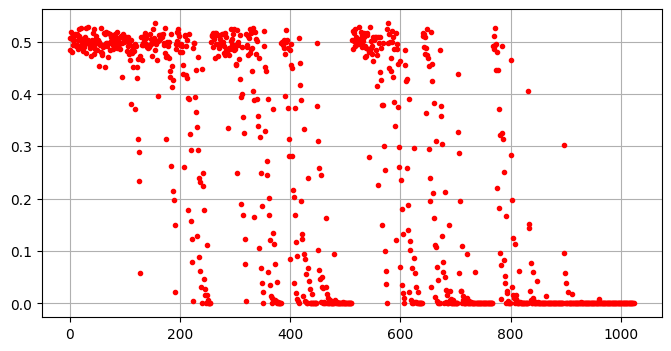

In [4]:
# 绘制这N个极化信道的错传率
error_times = np.zeros(shape=(N,))
for i in range(1000):
    error_times += simulate() / 1000
plt.figure(figsize=(8, 4))
plt.plot(error_times, 'r.')
plt.grid()

从上图中可以看出，使用Monte-Carlo法估计错判率的精度是比较差的。实际上，Arikan的建议是统计它们Bhattacharyya参数：

$$\sqrt{P(0)P(1)},\text{where: }P(u)\triangleq\Pr(U_i=u|Y_{1:N}=y_{1:N},U_{1:i-1}=u_{1:i-1})$$

修正后的代码如下：

In [5]:
def simulate():
    # 生成一批输入输出数据
    u = np.random.choice(a=q, p=np.array([0.5, 0.5]), size=(N,))
    x = plcoding.basic_encode(u)[plcoding.bitrev_perm(N)]
    y = np.mod(x + (np.random.rand(N) < flip_prob), q)
    # 使用极化迭代器计算N个极化信道对应的条件概率
    Px = np.empty(shape=(N, q))
    Px[np.arange(N), y] = 1 - flip_prob
    Px[np.arange(N), 1 - y] = flip_prob
    pIter.set_priors(Px)
    # 开始迭代计算
    Pu = np.empty_like(Px)
    pIter.reset()
    for i in range(N):
        Pu[i, :] = pIter.get_prob(i)
        pIter.set_value(i, u[i])
    return np.sqrt(np.prod(Pu, axis=1))

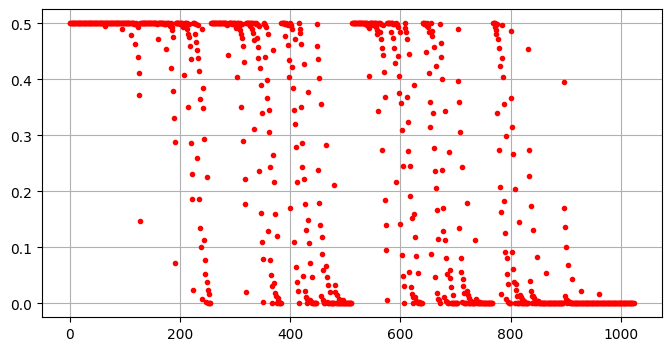

In [ ]:
# 绘制这N个极化信道的Z参数
error_times = np.zeros(shape=(N,))
for i in range(1000):
    error_times += simulate() / 1000
plt.figure(figsize=(8, 4))
plt.plot(error_times, 'r.')
plt.grid()

可以发现准确度高了很多，直观上可以理解为省去了判决的过程，直接使用了在每次实验中的错判率期望值。

---

# 2. 密度演化算法

密度演化算法（Density Evolution Algorithm）是LDPC中使用的一类算法……未完待续